# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd # импорт библиотек
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
!pip3 install catboost
from catboost import CatBoostRegressor
!pip3 install xgboost
import xgboost as xgb
!pip3 install lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from datetime import datetime

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv') # присвоим имя переменной файлу
except:
    data = pd.read_csv('C:/Users/Елена/Downloads/autos.csv')

In [3]:
data.info() # посмотрим на содержание, тип файлов, пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head() # посмотрим на первые неск строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Для визуализации построим таблицу, в которой укажем количество пропусков и их процент от общего количества

In [5]:
columns_list = data.columns

quantity = data[columns_list].isna().sum()
pers = round((data[columns_list].isna().sum()/len(data[columns_list])*100),2)
dat = {'Количество пропусков': quantity, 'Процент пропусков': pers}
df = pd.DataFrame(dat, index=data.columns)
df

,Количество пропусков,Процент пропусков
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


Посмотрим на уникальные значения в каждом столбце

In [6]:
for colm in columns_list:
    print('---')
    print(colm, data[colm].sort_values().unique())

---
DateCrawled ['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
---
Price [    0     1     2 ... 19998 19999 20000]
---
VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
---
RegistrationYear [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911

DateCreated ['2014-03-10 00:00:00' '2015-03-20 00:00:00' '2015-06-18 00:00:00'
 '2015-08-07 00:00:00' '2015-08-10 00:00:00' '2015-09-04 00:00:00'
 '2015-09-09 00:00:00' '2015-11-02 00:00:00' '2015-11-08 00:00:00'
 '2015-11-10 00:00:00' '2015-11-12 00:00:00' '2015-11-17 00:00:00'
 '2015-11-23 00:00:00' '2015-11-24 00:00:00' '2015-12-05 00:00:00'
 '2015-12-06 00:00:00' '2015-12-17 00:00:00' '2015-12-27 00:00:00'
 '2015-12-30 00:00:00' '2016-01-02 00:00:00' '2016-01-03 00:00:00'
 '2016-01-06 00:00:00' '2016-01-07 00:00:00' '2016-01-08 00:00:00'
 '2016-01-10 00:00:00' '2016-01-13 00:00:00' '2016-01-15 00:00:00'
 '2016-01-16 00:00:00' '2016-01-17 00:00:00' '2016-01-18 00:00:00'
 '2016-01-19 00:00:00' '2016-01-20 00:00:00' '2016-01-22 00:00:00'
 '2016-01-23 00:00:00' '2016-01-24 00:00:00' '2016-01-25 00:00:00'
 '2016-01-26 00:00:00' '2016-01-27 00:00:00' '2016-01-28 00:00:00'
 '2016-01-29 00:00:00' '2016-01-30 00:00:00' '2016-01-31 00:00:00'
 '2016-02-01 00:00:00' '2016-02-02 00:00:00' '2016

Построим ящик с усами и диаграммы для столбцов, которые содержат цифровые значения и которые имеют для нас значение. Не будем строить ящик с усами для почтового индекса, к примеру.

---
AxesSubplot(0.125,0.125;0.775x0.755)
---
AxesSubplot(0.125,0.125;0.775x0.755)
---
AxesSubplot(0.125,0.125;0.775x0.755)
---
AxesSubplot(0.125,0.125;0.775x0.755)


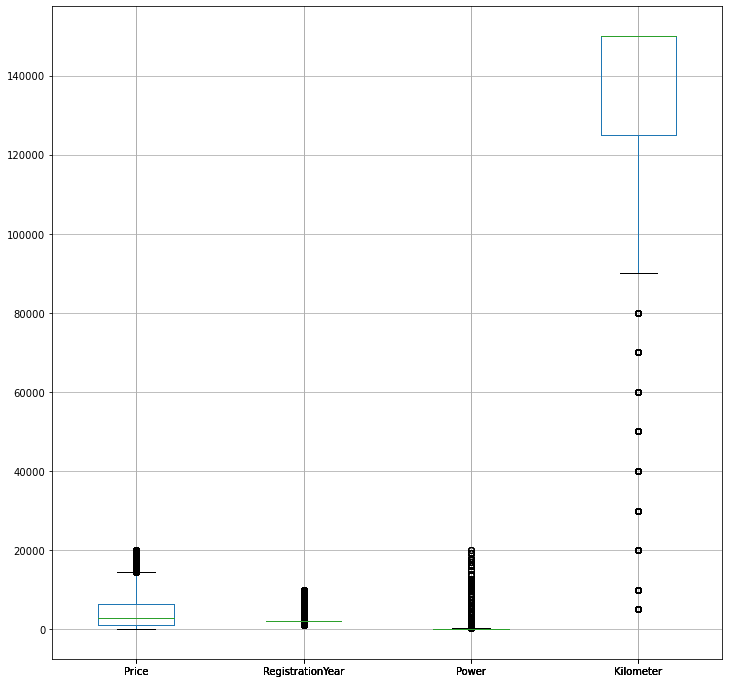

In [7]:
columns_list1 = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
for colm in (columns_list1):
    print('---')
    print(data.boxplot(columns_list1, figsize=(12,12)))

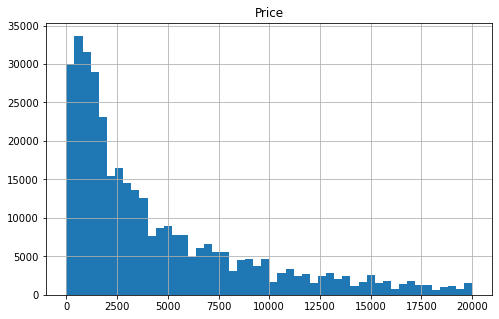

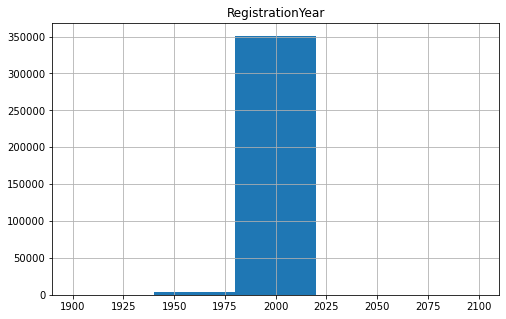

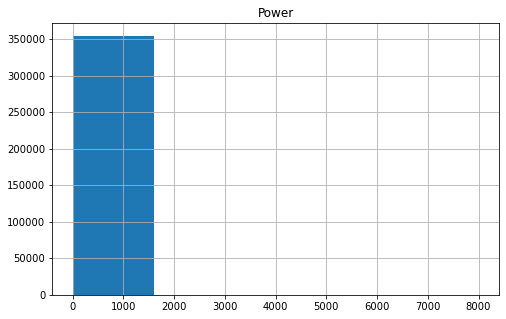

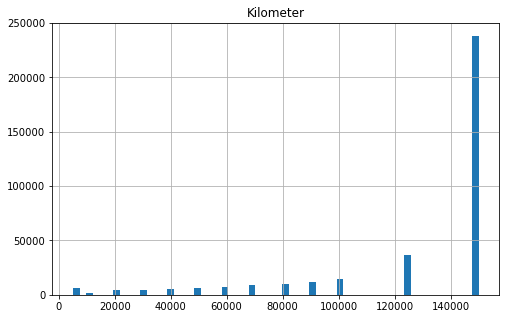

In [8]:
columns_df = pd.DataFrame(data, columns=['Price', 'RegistrationYear', 'Power', 'Kilometer'])
for_range = pd.Series([(0,20000),(1900,2100),(0,8000),(5000,150000)])
for_bins = pd.Series([50, 5, 5, 60])
for col,ran,bins in zip(columns_df,for_range, for_bins):
    columns_df.hist(col, bins = bins, range = ran ,figsize=(8,5))

Отдельно еще раз выведем минимальные и максимальные значения для интересующих нас столбцов.

In [9]:
columns_list1 = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
for colm in columns_list1:
    print('---')
    print(colm, data[colm].min(), data[colm].max())

---
Price 0 20000
---
RegistrationYear 1000 9999
---
Power 0 20000
---
Kilometer 5000 150000


Посмотрим есть ли у нас дубликаты

In [10]:
data.duplicated().sum()

4

Кажется странным Мощность равная 0, посмотрим на эти строки.

In [11]:
data.loc[data['Power'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


Выводы, которые можно сделать после анализа данных:
1. Мы можем удалить столбцы "PostalCode", "DateCrawled", "RegistrationMonth", "LastSeen" — дата скачивания анкеты из базы, 
месяц регистрации автомобиля, дата создания анкеты, дата последней активности пользователя - эти данные точно не влияют на цену и, соответственно, только помешают обучению модели
2. Столбец "NumberOfPictures" тоже придется удалить, тк он пустой, во всех объявлениях отсутствуют фотографии.
3. Много пропусков в столбце "NotRepaired", была ли машина в ремонте. Смею предположить, что если значение не заполнено, то "по умолчанию" - не была в ремонте. Поэтому далее заполним пропуск в этой графе на значение "нет".
4. Много странных значений в столбце с годом регистрации - от 1000 до 9999. Отберем для обучения только объявления с реальными значениями от 1910 до 2019 года. Хотя и 1910, возможно, рано.
5. Не будем удалять строки с мощностью 0, их достаточно много.
6. Достаточно много пропусков в Модели, Типе топлива, кузова и коробки передач. Заполним пропуски на заглушки, чтобы не терять так много данных
7. Удалим значения с выбивающейся ценой - с нулем значением и более 14 тыс (по ящику с усами)
8. Так же ориентируясь на гистограммы и ящик с усами удалим выбивающиеся значения по километражу и мощности.
9. Конечно удалим дубликаты

In [12]:
# удаляем ненужные столбцы
data = data.drop(['DateCrawled','PostalCode','LastSeen','NumberOfPictures','DateCreated','RegistrationMonth'], axis=1) 

In [13]:
# заполняем пропуски
data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [14]:
# заполняем пропуски
data[['Model', 'VehicleType','FuelType','Gearbox']] = data[['Model', 
                                                                    'VehicleType','FuelType','Gearbox']].fillna('Unknown')

In [15]:
# удаляем дубликаты
data = data.drop_duplicates()

In [16]:
# делаем копию и убираем выбивающиеся значения уже на копии файла
data_new = data.copy()
data_new = data_new.query('Price < 14000 & Price > 0 & RegistrationYear <= 2016 & RegistrationYear >= 1910 & Power < 15000 & Kilometer > 9000')

Посмотрим еще раз на ящик с усами на новых данных

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


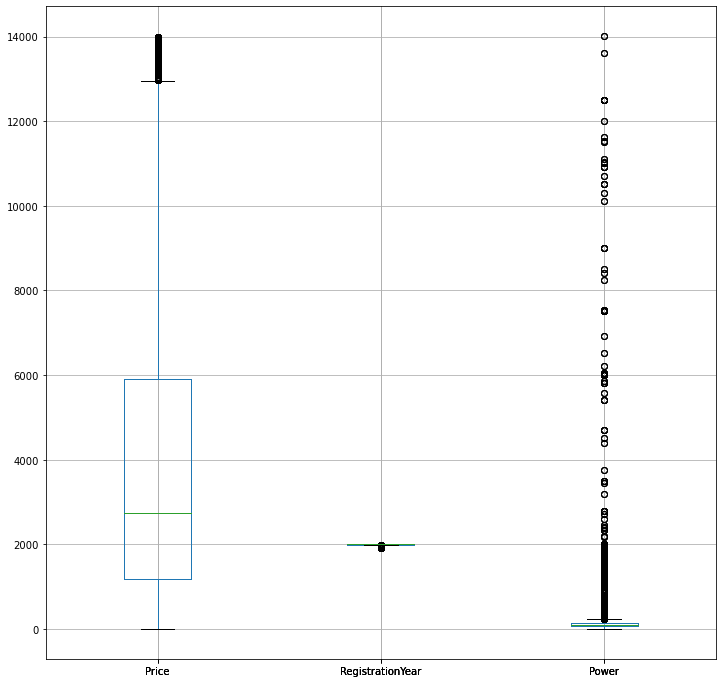

In [17]:
columns_list1 = ['Price', 'RegistrationYear', 'Power']
for colm in (columns_list1):
    print(data_new.boxplot(columns_list1, figsize=(12,12)))

In [18]:
'Доля удаленных значений составляет: {:.2%}'.format((len(data['Price'])-len(data_new['Price']))/len((data['Price'])))

'Доля удаленных значений составляет: 14.50%'

Удалили чуть около 15% от общего количества данных, можно работать дальше

Для правильного обучения всех моделей уберем категориальные значения

In [19]:
ordinal_columns = ['VehicleType','Brand','Gearbox','NotRepaired','Model','FuelType']
encoder = OrdinalEncoder()
data_new[ordinal_columns] = encoder.fit_transform(data_new[ordinal_columns])

In [20]:
features = data_new.drop('Price', axis=1) # выделим признаки и целевой признак в отдельные переменные
target = data_new['Price']

In [21]:
# создадим обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.20, 
                                                                              random_state = 42)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size = 0.25, 
                                                                              random_state = 42)

In [22]:
# изучим их объем
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((155097, 9), (155097,), (51700, 9), (51700,), (51700, 9), (51700,))

## Обучение моделей

### Дерево решений

Принимать решение о лучшей модели мы будем на основе времени обучений и предсказания и на основе метрики rmse. Поэтому напишем функции для расчета rmse

In [23]:
def rmse(targ, pred):
    return mean_squared_error(targ, pred) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [24]:
%%time 
start_time_1 = datetime.now()

# используем функционал gridsearch для автоматического поиска параметров

parametrs = {'max_depth': range(10,20)}
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), parametrs, cv=5, scoring=rmse_scorer)

grid.fit(features_train, target_train)
end_time_1 = datetime.now()

start_time_2 = datetime.now()
predictions = grid.predict(features_train)
print(grid.best_estimator_,
       grid.best_score_)

rmse_1 = - grid.best_score_

end_time_2 = datetime.now()
time_1_1 = end_time_1 - start_time_1
time_1_2 = end_time_2 - start_time_2
print(time_1_1, time_1_2)

DecisionTreeRegressor(max_depth=13, random_state=42) -1640.036478326463
0:00:20.173507 0:00:00.039407
Wall time: 20.2 s


### XGBoost 

In [25]:
%%time

start_time_1 = datetime.now()

model = xgb.XGBRegressor()
model.fit(features_train, target_train)

end_time_1 = datetime.now()

start_time_2 = datetime.now()
predictions = model.predict(features_valid)
rmse_2 = rmse(target_valid, predictions)

end_time_2 = datetime.now()
time_2_1 = end_time_1 - start_time_1
time_2_2 = end_time_2 - start_time_2

print(rmse_2); 
print(model)
print(time_2_1, time_2_2)

1388.2957962138041
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
0:00:03.690004 0:00:00.029431
Wall time: 3.72 s


### CatBoost

In [26]:
%%time

start_time_1 = datetime.now()
model = CatBoostRegressor(loss_function="RMSE", iterations=50)
model.fit(features_train, target_train, verbose=10)
end_time_1 = datetime.now()

start_time_2 = datetime.now()
predictions = model.predict(features_valid)
rmse_3 = rmse(target_valid, predictions)

end_time_2 = datetime.now()

time_3_1 = end_time_1 - start_time_1
time_3_2 = end_time_2 - start_time_2

print(rmse_3)
print(time_3_1,time_3_2)

Learning rate set to 0.5
0:	learn: 2516.6816047	total: 189ms	remaining: 9.25s
10:	learn: 1606.9821488	total: 391ms	remaining: 1.39s
20:	learn: 1530.1348202	total: 546ms	remaining: 755ms
30:	learn: 1485.7742212	total: 715ms	remaining: 438ms
40:	learn: 1461.6687384	total: 867ms	remaining: 190ms
49:	learn: 1441.0794476	total: 1s	remaining: 0us
1467.0096127064253
0:00:01.125323 0:00:00.026930
Wall time: 1.15 s


### LightGBM 

In [27]:
%%time

start_time_1 = datetime.now()

model = lgb.LGBMRegressor(objective='regression',num_leaves=51,learning_rate=1.05,n_estimators=50)
model.fit(features_train, target_train)
end_time_1 = datetime.now()

start_time_2 = datetime.now()
predictions = model.predict(features_valid)
rmse_4 = rmse(target_valid, predictions)

end_time_2 = datetime.now()

time_4_1 = end_time_1 - start_time_1
time_4_2 = end_time_2 - start_time_2

print(rmse_4)
print(time_4_1, time_4_2)
print(model)

1477.9323736171473
0:00:00.484537 0:00:00.033908
LGBMRegressor(learning_rate=1.05, n_estimators=50, num_leaves=51,
              objective='regression')
Wall time: 519 ms


### Линейная регрессия 

In [28]:
%%time

start_time_1 = datetime.now()
model = LinearRegression()  # обучаем модель
model.fit(features_train,target_train)
end_time_1 = datetime.now()

start_time_2 = datetime.now()
predictions = model.predict(features_valid)
rmse_5 = rmse(target_valid, predictions)

end_time_2 = datetime.now()
time_5_1 = end_time_1 - start_time_1
time_5_2 = end_time_2 - start_time_2

print(rmse_5)
print(time_5_1,time_5_2)

2887.4819052460284
0:00:00.046409 0:00:00.003990
Wall time: 52.4 ms


## Анализ моделей

In [29]:
rmse_list = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]
time_list_1 = [time_1_1,time_2_1,time_3_1,time_4_1,time_5_1]
time_list_2 = [time_1_2,time_2_2,time_3_2,time_4_2,time_5_2]

compare = {'RMSE': rmse_list, 'Время обучения': time_list_1, 'Время предсказания':time_list_2 }

compare_df = pd.DataFrame(compare, index=['DTR','XGBoost','CatBoost','LightGBM', 'Линейная регрессия'])
compare_df

,RMSE,Время обучения,Время предсказания
DTR,1640.036478,0 days 00:00:20.173507,0 days 00:00:00.039407
XGBoost,1388.295796,0 days 00:00:03.690004,0 days 00:00:00.029431
CatBoost,1467.009613,0 days 00:00:01.125323,0 days 00:00:00.026930
LightGBM,1477.932374,0 days 00:00:00.484537,0 days 00:00:00.033908
Линейная регрессия,2887.481905,0 days 00:00:00.046409,0 days 00:00:00.003990


Из таблицы видно, что самым быстрым оказалась модель Линейная реграссия, но у нее самое плохое качество, самое лучшее качество по метрике rmse у XGBoost. На ней и остановимся для проверки на тестовой выборке.

In [30]:
%%time
model = xgb.XGBRegressor()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse_3 = rmse(target_test, predictions)
print(rmse_3)

1390.5390067935841
Wall time: 3.53 s


На тестовой выборке качество осталось почти неизменным! И по скорости обучения и предсказания модель все так же показывает быстрый результат

Вывод.
1. Мы провели анализ данных объявлений сервиса по продаже автомобилей с пробегом. В ходе предобработки данных мы изучили их состав, удалили редкие, выбивающиеся значения, поставили заглушки в пропуски, где не смогли заполнить иными подходящими данными, удалили дубликаты и ненужные столбцы, которые могли помешать модели обучаться.
2. Затем мы рассмотрели 5 моделей обучения, две из которых не бустинг, а Дерево Решений с подбором гиперпараметров через GridSearch и Линейная регрессия
3. Изучили скорость обучения моделей и качество метрики по rmse.
4. Выбрали таким образом наиболее подходящую модель и проверили ее работу на тестовой выборке.